In [1]:
import torch
import timm
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def visualize_matrices_side_by_side(matrices, titles):
    fig, axes = plt.subplots(1, len(matrices), figsize=(15, 5))
    for ax, matrix, title in zip(axes, matrices, titles):
        ax.imshow(matrix, cmap='viridis')
        ax.set_title(title)
        ax.axis('off')
    plt.colorbar(axes[-1].imshow(matrices[-1], cmap='viridis'), ax=axes.ravel().tolist())
    plt.show()

## vit_tiny

In [2]:
vit_tiny_patch16_384 = timm.create_model("vit_tiny_patch16_384", pretrained=True)

In [3]:
state_dict = vit_tiny_patch16_384.state_dict()

In [8]:
layer_id = 4

In [1]:
W_qkv = state_dict["blocks.{}.attn.qkv.weight".format(layer_id)].t()  # Transpose to split correctly
# Splitting the combined matrix to get individual matrices for each head
W_q, W_k, W_v = torch.chunk(W_qkv, 3, dim=1)  # Split along the column dimension

# Since there are 3 heads, we further split each matrix along the row dimension
W_qs = torch.chunk(W_q, 3, dim=0)
W_ks = torch.chunk(W_k, 3, dim=0)
W_vs = torch.chunk(W_v, 3, dim=0)

W_proj = state_dict["blocks.0.attn.proj.weight"]
# Split W_proj along its column dimension
W_projs = torch.chunk(W_proj, 3, dim=0)

# Compute W_q * W_k^T for each head
matrix_q_k = [torch.mm(W_qs[i], W_ks[i].t()).detach().numpy() for i in range(3)]

visualize_matrices_side_by_side(matrix_q_k, [f"W_q * W_k^T for head {i+1}" for i in range(3)])

matrix_v_proj = [torch.mm(W_vs[i], W_projs[i].t()).detach().numpy() for i in range(3)]
visualize_matrices_side_by_side(matrix_v_proj, [f"W_v * W_proj for head {i+1}" for i in range(3)])

NameError: name 'state_dict' is not defined

### arrange all

In [10]:
# Initialize containers for all blocks' weights
W_q_all, W_k_all, W_v_all, W_proj_all = [], [], [], []

for block_idx in range(12):
    prefix = f"blocks.{block_idx}.attn."

    W_qkv = state_dict[prefix + "qkv.weight"].t()  # Transpose for splitting
    W_q, W_k, W_v = torch.chunk(W_qkv, 3, dim=1)
    W_q_all.append(torch.chunk(W_q, 3, dim=0))
    W_k_all.append(torch.chunk(W_k, 3, dim=0))
    W_v_all.append(torch.chunk(W_v, 3, dim=0))
    W_proj_all.append(torch.chunk(state_dict[prefix + "proj.weight"], 3, dim=0))

matrix_q_k_all = [[torch.mm(W_q_all[block][head], W_k_all[block][head].t()).detach().numpy() 
                   for head in range(3)] 
                  for block in range(12)]

matrix_v_proj_sum_all = [sum([torch.mm(W_v_all[block][head], W_proj_all[block][head].t()).detach().numpy() 
                              for head in range(3)]) 
                         for block in range(12)]

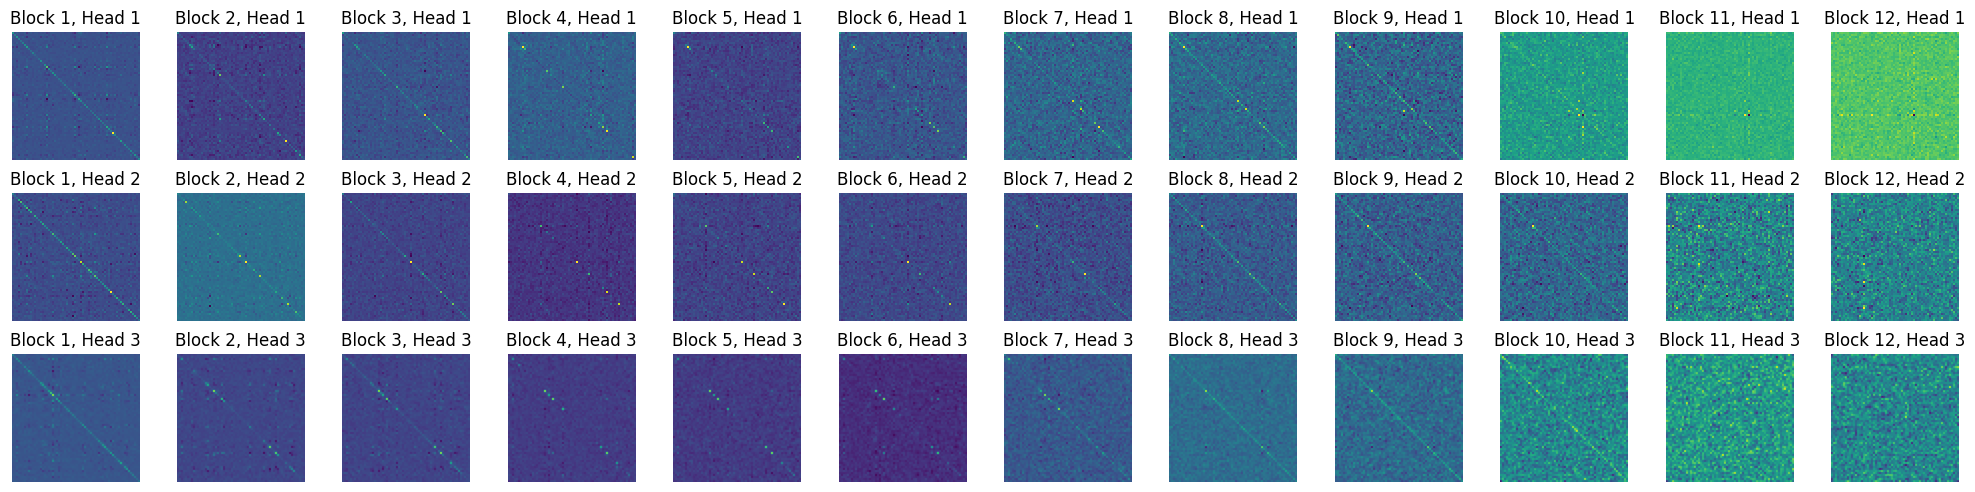

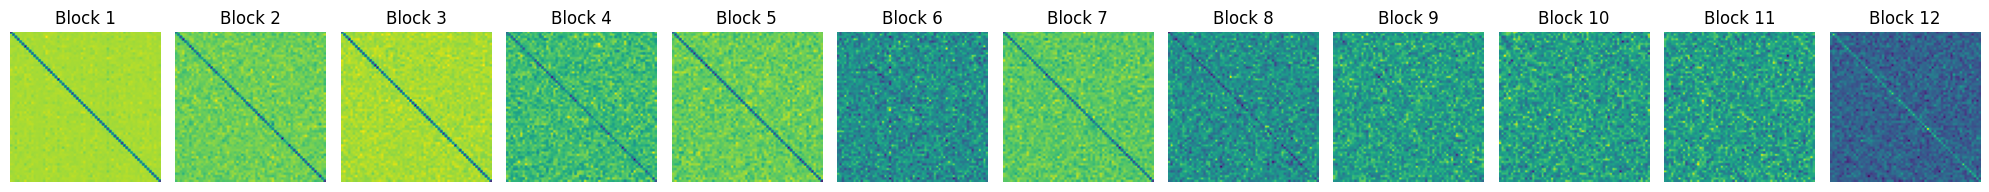

In [11]:
import matplotlib.pyplot as plt

# Visualization Function for W_q * W_k^T
def visualize_qk_as_pdf(matrix_q_k_all, filename):
    nblocks, nheads = len(matrix_q_k_all), len(matrix_q_k_all[0])
    fig, axes = plt.subplots(nheads, nblocks, figsize=(20, 5))
    
    for block_idx in range(nblocks):
        for head_idx in range(nheads):
            ax = axes[head_idx][block_idx]
            ax.imshow(matrix_q_k_all[block_idx][head_idx], cmap='viridis')
            ax.set_title(f"Block {block_idx+1}, Head {head_idx+1}")
            ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename, format="pdf", bbox_inches='tight')

visualize_qk_as_pdf(matrix_q_k_all, "W_q_W_k_T.pdf")

# Visualization Function for Sum of W_v * W_proj
def visualize_v_proj_sum_as_pdf(matrix_v_proj_sum_all, filename):
    fig, axes = plt.subplots(1, len(matrix_v_proj_sum_all), figsize=(20, 2))
    
    for block_idx, matrix in enumerate(matrix_v_proj_sum_all):
        ax = axes[block_idx]
        ax.imshow(matrix, cmap='viridis')
        ax.set_title(f"Block {block_idx+1}")
        ax.axis('off')
    plt.tight_layout()
    plt.savefig(filename, format="pdf", bbox_inches='tight')

visualize_v_proj_sum_as_pdf(matrix_v_proj_sum_all, "W_v_W_proj_sum.pdf")
